In [1]:
import os,glob,re
import pandas as pd
import numpy as np
from Bio import SeqIO
from natsort import natsorted
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [2]:
path = '/data/shangzhong/Proteogenomics/event_results'
vcf_path = '/data/shangzhong/Proteogenomics/Database/SNP_Database_Generate/anno_vcf'
ref_fa = '/data/genome/hamster/picr_old/picr.fa'
pasa_path = '/data/shangzhong/Picr_assembly/Annotation/PASA/pasa_stringtie'
event = path + '/all_events.txt'
gff = pasa_path + '/03_pasa_stringtie.gff3'
splice_fn = path + '/splice.txt'
snpdb_ins_fn = path + '/insertion.txt'
snpdb_del_fn = path + '/deletion.txt'
snpdb_snp_fn = path + '/snp.txt'
#gff = '/data/genome/hamster/picr_old/updated_final.gff3'

First of all, merge all events files from multiple runs. Then get unique events, sum all he spectrum count, location count is the same for all runs. FDR take the maximum, Sprob take the minimum. 

In [3]:
def f(x):
    '''this function groups all the events from different runs'''
    d = {}
    d['spec_count'] = x['spec_count'].sum()
    d['location_count']=x['location_count'].max()
    d['FDR'] = x['FDR'].max()
    d['Sprob']=x['Sprob'].min()
    infos = []
    for i in x['GroupInfo'].tolist():
        if i != 'nan':
            infos.extend(i.split('|'))
    infos = list(set(infos))
    infos = [f for f in infos if f != '']
    d['NumOfGroup'] = len(infos)+1
    d['GroupInfo']='|'.join(infos)
    return pd.Series(d)
event_df = pd.read_csv(event,sep='\t',header=0)
event_df['GroupInfo'] = event_df['GroupInfo'].astype('str')
event_df = event_df.groupby(['Event','Peptide','Chromosome','Location','Strand']).apply(f)
event_df.reset_index(inplace=True)

In [4]:
event_df['Event'].value_counts()

mutation                    1934
novel splice                1747
transcript gene(non CDS)     114
frame shift                  105
alternative splice            94
insertion                     57
IG gene                       46
reverse strand                37
fusion gene                   25
novel gene                    12
deletion                       7
Name: Event, dtype: int64

### Analyze fusion genes in the file

In [5]:
def get_splice_dic(splice_fn):
    # get dictionary {[chr,s,e,str]:number of reads}
    splice_dic = {}
    with open(splice_fn) as f:
        for line in f:
            if line.startswith('#'): continue
            item = line.strip().split('\t')
            num = sum([int(n.split(':')[1]) for n in item[3].split(',')])
            key = item[:3]+[item[4]]
            splice_dic[';'.join(key)] = num
    return splice_dic

splice_dic = get_splice_dic(splice_fn)

Since splicedb builds database on both strands, therefore, for some fusion events, the peptide s overlap with genes on different strands. Another case is that the fused genes on both ends are the same gene, which means the gene has multiple copies in the genome.

In [6]:
def extract_feature_gff(gff_df,feature,geneid=False):
    '''extract feature dataframe'''
    df = gff_df[gff_df['feature'].values == feature]
    df = df.reset_index(drop=True)
    df['s'] -= 1
    df['gene'] = df['anno'].map(lambda x: re.search('(?<=Name=).+?(?=;|$)',x).group(0))
    if geneid:
        df['gene_id'] = df['anno'].map(lambda x: re.search('(?<=gene_id=).+?(?=;|$)',x).group(0))
    del df['anno']
    return df
# get gff df
gff_df = pd.read_csv(gff,sep='\t',header=None,comment='#',names=['chr','source','feature',
                            's','e','none','str','frame','anno'])
cds_df = extract_feature_gff(gff_df,'exon')
rna_df = extract_feature_gff(gff_df,'mRNA')
# build gene id name dictonary
gene_df = extract_feature_gff(gff_df,'gene',geneid=True)
id_name_dic = gene_df.set_index('gene_id')['gene'].to_dict()

In [7]:
def get_gene(row,cds_df,direction='same'):
    '''this function gets the fusion genes using peptide splice information.
    genes on sides of splice is split by comma, if one splice map to more than one 
    gene, the overlapped genes are split by ; '''
    chrom = row['Chromosome']
    loci = row['Location']
    strand = row['Strand']
    if direction == 'diff':
        if strand == '+':
            strand = '-'
        else:
            strand = '+'
    genes = []
    locis = loci.split(';')
    for loc in locis:
        pos = [int(p) for p in loc.split('-')]
        fil_gff = cds_df[(cds_df['chr'].values==chrom)&(cds_df['str'].values==strand)]
        cri = fil_gff.apply(lambda x:range(max(x['s'],pos[0]),min(x['e'],pos[1]))!=[],axis=1)
        fil_gff = fil_gff[cri]                
        gene = fil_gff['gene'].unique().tolist()
        if len(gene)>1:
            print loc,'has two genes',gene
        genes.append(';'.join(gene))
    return ','.join(genes)

def get_read_num(row,splice_dic):
    '''this function gets the number of reads supporting the event'''
    loci = row['Location'].split(';')
    pos = []
    for i in range(len(loci)-1):
        s = loci[i].split('-')[1]
        e = loci[i+1].split('-')[0]
        pos.append([s,e])
    reads = []
    for p in pos:
        key = ';'.join([row['Chromosome']]+p+[row['Strand']])
        try:
            reads.append(splice_dic[key])
        except:
            print key,'is not in dictionary'
            reads.append(0)
    return ','.join([str(r) for r in reads])

def fusion_filter(genes):
    '''this function keeps the events whose both ends have annotated genes
    on the same strand
    input is genes column of fusion_df
    '''
    gene = [g for g in genes.strip().split(',') if g !='']
    if len(gene)<=1:
        return 'no'
    else:
        if len(set(gene))==1:
            return 'same'
        else:
            return 'yes'

In [8]:
def process_event_with_splice(df,exon_df,splice_dic):
    df['genes'] = df.apply(lambda x:get_gene(x,exon_df),axis=1)
    df['read_num'] = df.apply(lambda x:get_read_num(x,splice_dic),axis=1)
    df = df.query('read_num != "0"')
    df = df.reset_index(drop=True)
    return df

In [9]:
fusion_df = event_df[event_df['Event'].values=='fusion gene']
fusion_df = fusion_df.reset_index(drop=True)
fusion_df = process_event_with_splice(fusion_df,cds_df,splice_dic)
fusion_df['keep'] = fusion_df['genes'].map(lambda x:fusion_filter(x))
fusion_df = fusion_df.query('keep != "no"')
fusion_df = fusion_df.reset_index(drop=True)

8769020-8769056 has two genes ['HSH2D', 'RAB8A']
8973929-8973938 has two genes ['ZNF709', 'ZNF844']
8546964-8547037 has two genes ['HDGF', 'ISG20L2']
809141-809174 has two genes ['NCAPD2', 'GAPDH']


In [10]:
fusion_df['keep'].value_counts()

yes    17
Name: keep, dtype: int64

In [11]:
fusion_fn = path + '/01_fusion.txt'
fusion_df.to_csv(fusion_fn,sep='\t',index=False)

#### Analyze alternative splice

In [12]:
alter_splice_df = event_df.query('Event == "alternative splice"')
alter_splice_df = alter_splice_df.reset_index(drop=True)
alter_splice_df = process_event_with_splice(alter_splice_df,cds_df,splice_dic)
fail_alter_splice_df = alter_splice_df.query('genes==","')
alter_splice_df = alter_splice_df.query('genes != ","')
alter_splice_df['genes'] = alter_splice_df['genes'].map(lambda x: ','.join(list(set(x.split(',')))))

9150872-9150905 has two genes ['SPAST', 'SLC30A6']
9152949-9152952 has two genes ['SPAST', 'SLC30A6']
8769020-8769056 has two genes ['HSH2D', 'RAB8A']
8775668-8775677 has two genes ['HSH2D', 'RAB8A']
19649594-19649641 has two genes ['gene_339', 'HNRNPA1', 'NFE2']
12426265-12426268 has two genes ['SET', 'gene_22189']
12426631-12426664 has two genes ['SET', 'gene_22189']
376346-376363 has two genes ['gene_9603', 'FXYD5']
377561-377586 has two genes ['gene_9603', 'FXYD5']
19648176-19648180 has two genes ['HNRNPA1', 'NFE2']
19649594-19649641 has two genes ['gene_339', 'HNRNPA1', 'NFE2']
746341-746342 has two genes ['LOC103159745', 'ESX1']
8968605-8968610 has two genes ['SNX14', 'SYNCRIP']


In [13]:
print 'there are', alter_splice_df.shape[0],'alternative splice events',
alter_splice_fn = path + '/02_alter_splice.txt'
alter_splice_df.to_csv(alter_splice_fn,sep='\t',index=False)

there are 94 alternative splice events


#### Analyze novel splice

In [14]:
novel_splice_df = event_df.query('Event == "novel splice"')
novel_splice_df = novel_splice_df.reset_index(drop=True)
novel_splice_df = process_event_with_splice(novel_splice_df,cds_df,splice_dic)

809315-809348 has two genes ['NCAPD2', 'GAPDH']
809633-809697 has two genes ['NCAPD2', 'GAPDH']
809615-809697 has two genes ['NCAPD2', 'GAPDH']
7463667-7463697 has two genes ['MAST3', 'PIK3R2']
7464825-7464828 has two genes ['MAST3', 'PIK3R2']
8171069-8171105 has two genes ['HNRNPA3', 'NFE2L2', 'gene_3327', 'RO31_XENLA']
8171228-8171231 has two genes ['HNRNPA3', 'NFE2L2', 'gene_3327', 'RO31_XENLA']
81798-81825 has two genes ['POLDIP3', 'CYB5R3']
88157-88160 has two genes ['POLDIP3', 'CYB5R3']
1402834-1402870 has two genes ['TBB7_CHICK', 'TUBB']
1403014-1403017 has two genes ['TBB7_CHICK', 'TUBB']
8801786-8801822 has two genes ['ZSWIM3', 'ZSWIM1']
8802040-8802043 has two genes ['ZSWIM3', 'ZSWIM1']
8944898-8944949 has two genes ['RNF123', 'APEH']
8945109-8945112 has two genes ['RNF123', 'APEH']
12056441-12056510 has two genes ['AKAP8L', 'AKAP8']
12056623-12056626 has two genes ['AKAP8L', 'AKAP8']
5279189-5279231 has two genes ['DIO1', 'gene_22475']
5282197-5282200 has two genes ['DIO1', 

In [15]:
novel_splice_df = novel_splice_df[novel_splice_df['read_num'].map(lambda x: x!='0' and '0,' \
                                                not in x and ',0' not in x)]
fail_novel_splice_df = novel_splice_df.query('genes==","')
novel_splice_df = novel_splice_df.query('genes!=","')
print 'there are',novel_splice_df.shape[0],'novel splice events'

there are 1692 novel splice events


In [16]:
novel_splice_df['genes'] = novel_splice_df['genes'].map(lambda x: ','.join(list(set(x.split(',')))))
novel_splice_fn = path + '/03_novel_splice.txt'
novel_splice_df.to_csv(novel_splice_fn,sep='\t',index=False)

#### Analyze novel gene
Novel gene is identified from splicedb or six frame db, so here we cannot use the function process_event_with_splice.
There are cases that it seems like the event is novel splice, but it's in different frame compared to the proteins, so the code assigns it to novel gene.

In [17]:
novel_gene_df = event_df.query('Event == "novel gene"')
novel_gene_df = novel_gene_df.reset_index(drop=True)

In [18]:
novel_gene_df['genes']=novel_gene_df.apply(lambda x: get_gene(x,cds_df),axis=1)
novel_gene_df['genes']=novel_gene_df['genes'].map(lambda x: x.split(',')[0])
novel_gene_df['read_num']=novel_gene_df.apply(lambda x: get_read_num(x,splice_dic),axis=1)
print 'there are',novel_gene_df.shape[0],'novel genes'

8340063-8340066 has two genes ['gene_16802', 'PTMA']
8340107-8340155 has two genes ['gene_16802', 'PTMA']
8339951-8339957 has two genes ['gene_16802', 'PTMA']
8340086-8340155 has two genes ['gene_16802', 'PTMA']
there are 12 novel genes


In [19]:
novel_gene_fn = path + '/04_novel_gene.txt'
novel_gene_df.to_csv(novel_gene_fn,sep='\t',index=False)

#### Analyze reverse event

In [20]:
def get_reverse_gene(row,cds_df,direction='same'):
    '''this function gets the fusion genes using peptide splice information.
    genes on sides of splice is split by comma, if one splice map to more than one 
    gene, the overlapped genes are split by ; '''
    chrom = row['Chromosome']
    loci = row['Location']
    strand = row['Strand']
    if direction == 'diff':
        if strand == '+':
            strand = '-'
        else:
            strand = '+'
    genes = []
    locis = loci.split(';')
    poses = []
    for loc in locis:
        pos = [int(p) for p in loc.split('-')]
        poses.extend(pos)
    pos = [min(poses),max(poses)]
    fil_gff = cds_df[(cds_df['chr'].values==chrom)&(cds_df['str'].values==strand)]
    cri = fil_gff.apply(lambda x:range(max(x['s'],pos[0]),min(x['e'],pos[1]))!=[],axis=1)
    fil_gff = fil_gff[cri]                
    gene = fil_gff['gene'].unique().tolist()
    if len(gene)>1:
        print loc,'has two genes',gene
    genes.append(';'.join(gene))
    return ','.join(genes)

In [21]:
reverse_df = event_df.query('Event == "reverse strand"')
reverse_df = reverse_df.reset_index(drop=True)

In [22]:
reverse_df['genes'] = reverse_df.apply(lambda x: get_reverse_gene(x,rna_df,'diff'),axis=1)
reverse_df['genes'] = reverse_df['genes'].map(lambda x: ','.join(list(set(x.split(',')))))
reverse_df['read_num'] = reverse_df.apply(lambda x: get_read_num(x,splice_dic),axis=1)

26608242-26608251 has two genes ['gene_6887', 'RPL8']
2901428-2901445 has two genes ['NRBF2', 'EIF1']
145735-145764 has two genes ['A4GALT', 'gene_4']


In [23]:
print 'there are',reverse_df.shape[0],'reverse events'
reverse_fn = path + '/05_reverse.txt'
reverse_df.to_csv(reverse_fn,sep='\t',index=False)

there are 37 reverse events


#### Analyze frame shift

In [25]:
def get_final_frame_shift_df(event_df,cds_df,splice_dic):
    frame_df = event_df.query('Event == "frame shift"')
    frame_df = frame_df.reset_index(drop=True)
    frame_df['genes']=frame_df.apply(lambda x: get_gene(x,cds_df),axis=1)
    frame_df['genes']=frame_df['genes'].map(lambda x: ','.join(list(set(x.split(',')))))
    frame_df['read_num']=frame_df.apply(lambda x: get_read_num(x,splice_dic),axis=1)
    return frame_df
frame_fn = path + '/06_frame_shift.txt'
if not os.path.exists(frame_fn):
    frame_df = get_final_frame_shift_df(event_df,cds_df,splice_dic)
    print 'there are',frame_df.shape[0],'frame shift events'
    frame_df.to_csv(frame_fn,sep='\t',index=False)
frame_df = pd.read_csv(frame_fn,sep='\t',header=0)

10049283-10049286 has two genes ['ELMOD3', 'TTGN1']
10050518-10050545 has two genes ['ELMOD3', 'TTGN1']
6856189-6856204 has two genes ['KTI12', 'TXNDC12']
6857891-6857948 has two genes ['KTI12', 'TXNDC12']
3234582-3234598 has two genes ['DRAP1', 'BLES03']
3234838-3234870 has two genes ['DRAP1', 'BLES03']
16546872-16546887 has two genes ['SEMA4G', 'LZTS2']
16547374-16547413 has two genes ['SEMA4G', 'LZTS2']
14120947-14120997 has two genes ['RPL23A', 'gene_27436']
14121511-14121533 has two genes ['RPL23A', 'gene_27436']
3421498-3421528 has two genes ['ACAP3', 'INTS11']
3421674-3421683 has two genes ['ACAP3', 'INTS11']
4946820-4946847 has two genes ['CUL4A', 'gene_4383']
4956469-4956493 has two genes ['CUL4A', 'gene_4383']
there are 105 frame shift events


### Analyze Mutation and INDEL
1. read in the mutation and indel position generated by snpdb.
2. extract protein verified snpdb.
3. merge all the annovar annotated vcf files and remove the duplicates. Then we analyze mutation, insertion and deletion separatly.
4. get overlap between 2 and 3.

* read in snpdb snp and indel

In [27]:
def get_snpdb_read_num(support):
    '''this function gets the number of reads supporting each mutation or indel from snpdb'''
    n = 0
    items = support.split(',')
    for item in items:
        n += int(item.split(':')[1])
    return n

# 1. read in snpdb generated mutation and indel
snpdb_snp_df = pd.read_csv(snpdb_snp_fn,sep='\t',comment='#',header=None,names=[
    'chr','s','alt','supt','read_num'])
snpdb_snp_df['read_num'] = snpdb_snp_df['supt'].map(lambda x: get_snpdb_read_num(x))
del snpdb_snp_df['supt']
snpdb_ins_df = pd.read_csv(snpdb_ins_fn,sep='\t',comment='#',header=None,names=[
    'chr','s','alt','supt','read_num'])
snpdb_ins_df['read_num'] = snpdb_ins_df['supt'].map(lambda x: get_snpdb_read_num(x))
del snpdb_ins_df['supt']
snpdb_del_df = pd.read_csv(snpdb_del_fn,sep='\t',comment='#',header=None,names=[
    'chr','s','e','supt','read_num'])
snpdb_del_df['read_num'] = snpdb_del_df['supt'].map(lambda x: get_snpdb_read_num(x))
del snpdb_del_df['supt']
snpdb_snp_df['e'] = snpdb_snp_df['s'] + 1
snpdb_ins_df['e'] = snpdb_ins_df['s'] + 1

* merge vcf files

In [28]:
def remove_mut_dup(x):
    '''this function removes duplications in merged annovar annotated vcf df'''
    d = {}
    d['anno'] = x['anno'].iloc[0]
    feature = x['feature'].unique()
    if len(feature)>1:
        d['feature'] = 'het'
    else:
        d['feature'] = feature[0]
    return pd.Series(d)

def merge_vcf_df(vcf_fns):
    '''merge annovar annotated vcf files'''
    vcf_dfs = []
    for vcf in vcf_fns:
        df = pd.read_csv(vcf,sep='\t',header=None,usecols=range(1,9))
        vcf_dfs.append(df)
    vcf_df = pd.concat(vcf_dfs)
    vcf_df.columns = ['type','anno','chr','s','e','ref','alt','feature']
    vcf_df = vcf_df.groupby(['type','chr','s','e','ref','alt']).apply(remove_mut_dup)
    vcf_df.reset_index(inplace=True)
    return vcf_df

In [29]:
merge_vcf_fn = path + '/merged.vcf'
if not os.path.exists(merge_vcf_fn):
    vcfs = natsorted(glob.glob(vcf_path+'/*exonic_variant_function'))
    vcf_df = merge_vcf_df(vcfs)
    vcf_df.to_csv(merge_vcf_fn,sep='\t',index=False)
vcf_df = pd.read_csv(merge_vcf_fn,sep='\t',header=0)
# filter out the synonymouse snv
fil_vcf_df = vcf_df[vcf_df['type'].values!='synonymous SNV']
fil_vcf_df = fil_vcf_df.reset_index(drop=True)

In [32]:
anno_vcf_stats = vcf_df['type'].value_counts().to_dict()
anno_vcf_stats_df = pd.DataFrame.from_dict(anno_vcf_stats,orient='index')
anno_vcf_stats_df.columns= ['number']
anno_vcf_stats_df = anno_vcf_stats_df.sort_values('number')
anno_vcf_stats_df

,number
stoploss,348
nonframeshift insertion,1522
stopgain,1563
nonframeshift deletion,1676
frameshift deletion,6303
frameshift insertion,7856
nonsynonymous SNV,218332
synonymous SNV,769252


#### 1. Analyze snp

In [37]:
def get_mut_pos(location,mut='snp'):
    '''this function gets the location of the mutation
    * mut: snp, ins, del
    '''
    locis = location.split(';')
    poses = []
    if mut == 'snp':
        symbol = 'M'
    elif mut == 'ins':
        symbol = 'I'
    if mut == 'del':
        for i in range(len(locis)-1):
            pos = [locis[i].split('-')[1],locis[i+1].split('-')[0]]
            poses.append('-'.join(pos))
    else:
        for i in range(len(locis)):
            if locis[i][0] == symbol:
                if i == 0: # need to get the next number
                    pos = int(locis[i+1].split('-')[0])-1
                else:
                    pos = int(locis[i-1].split('-')[1])
                poses.append('-'.join([str(pos),str(pos+1)]))
#         poses = [str(p) for p in poses]
    return ','.join(poses)


def getSnpPosPrDic(snp_event):
    '''build a dictionary {chr:pos:alt_AA : [number of pep,spec_count]} from proteogenomic mutation event'''
    mut_pos = {}
    for index,row in snp_event.iterrows():
        locis = row['Location'].split(';')
        chrom = row['Chromosome']
        pep = ''.join([l for l in row['Peptide'] if l.isalpha()])
        groups = len(row['GroupInfo'].split('|'))
        spec_count = int(row['spec_count'])
        idx = 0
    #     if row['Strand']=='-': locis = locis[::-1]
        for i in range(len(locis)):
            if 'M1' == locis[i]:
                idx_p = int(idx/3)
                if idx == 0:
                    pos = int(locis[1].split('-')[0])
                else:
                    pos = int(locis[i-1].split('-')[1]) + 1
                if row['Strand'] == '-':
                    idx_p = len(pep)-idx_p-1
                key = ':'.join([chrom,str(pos-1),pep[idx_p]])
                if key in mut_pos:
                    value = mut_pos[key]
                    value[0] += 1
                    value[1] += spec_count
                    mut_pos[key]=value
                else:
                    mut_pos[key] = [groups,spec_count]
                idx += 1
            else:
                pos = [int(p) for p in locis[i].split('-')]
                idx += pos[1]-pos[0]
    return mut_pos


def get_alter_pr_from_snp(row,mut_pos):
    '''this funcion 
    * row: a row of annovar annotated snp_df
    * mut_pos: {chr:start_pos:alter:[pep_num,spec_num]}'''
    annos = row['anno'].strip().split(',')[:-1]
    chrom = row['chr']
    start = row['s']
    new_annos = []
    spectrum = [0,0]
    for anno in annos:
        key = ':'.join([chrom,str(start),anno[-1]])
        if key in mut_pos:
            new_annos.append(anno)
            spectrum = mut_pos[key]
        else:
            pass
    row['anno'] = ','.join(new_annos)
    return pd.Series(spectrum)


def get_mut_genes(anno,id_name_dic):
    # get gene name from gene id in annotated results
    items = anno.split(',')[:-1]
    genes = []
    try:
        for item in items:
            genes.append(id_name_dic[item.split(':')[0]])
    except:
        print anno
    return ','.join(list(set(genes)))

In [34]:
def get_final_snp_event(event_df,snpdb_snp_df,fil_vcf_df,id_name_dic):
    '''this function gets all the snp events'''
    # 1. get proteogenomics verified mutation
    snp_event = event_df.query('Event=="mutation"')
    snp_pos_dic = getSnpPosPrDic(snp_event)  # {chr:pos:alt_AA : [pep_num,spec_num]}

    # 2. extract nonsynonymouse mutation from annotation 
    anno_snp_df = fil_vcf_df[fil_vcf_df.apply(lambda x:(x['alt']!='-') & (x['ref']!='-'),axis=1)]
    anno_snp_df = anno_snp_df.reset_index(drop=True)
    anno_snp_df['s'] -= 1
    # 3. overlap with snpdb_snp_df
    anno_snpdb_snp_df = pd.merge(anno_snp_df,snpdb_snp_df,on=['chr','s','e','alt'])
    anno_snpdb_snp_df[['pep_num','spec_num']] = anno_snpdb_snp_df.apply(lambda row: get_alter_pr_from_snp(row,snp_pos_dic),axis=1)
    anno_snpdb_snp_df = anno_snpdb_snp_df[anno_snpdb_snp_df['pep_num'].values>0]
    anno_snpdb_snp_df = anno_snpdb_snp_df.reset_index(drop=True)
    anno_snpdb_snp_df['gene'] = anno_snpdb_snp_df['anno'].map(lambda x:get_mut_genes(x,id_name_dic))
    anno_snpdb_snp_df.to_csv(snp_fn,sep='\t',index=False)
    return anno_snpdb_snp_df

In [38]:
snp_fn = path + '/07_snp_event.txt'
if not os.path.exists(snp_fn):
    final_anno_snp_df = get_final_snp_event(event_df,snpdb_snp_df,fil_vcf_df,id_name_dic)
    final_anno_snp_df.to_csv(snp_fn,sep='\t',index=False)

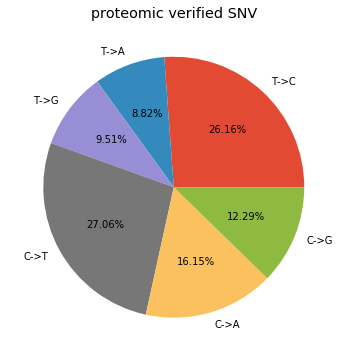

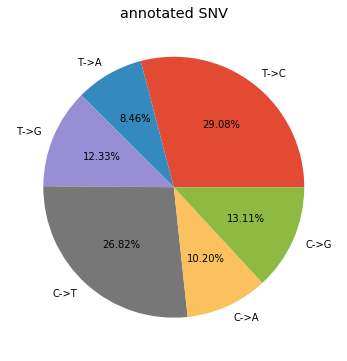

In [39]:
def plot_snp_df(snp_df,title):
    mut_rates = (snp_df['ref']+'->'+snp_df['alt']).value_counts().to_dict()
    mut_rates['C->A'] += mut_rates['G->T']
    mut_rates['C->G'] += mut_rates['G->C']
    mut_rates['C->T'] += mut_rates['G->A']
    mut_rates['T->A'] += mut_rates['A->T']
    mut_rates['T->C'] += mut_rates['A->G']
    mut_rates['T->G'] += mut_rates['A->C']
    for k in mut_rates.keys():
        if k[0] in ['G','A']:
            del mut_rates[k]

    mut_rates = pd.DataFrame.from_dict(mut_rates,orient='index')
    ax = mut_rates[0].plot.pie(figsize=(6,6),autopct='%.2f%%')
    _ = ax.set(ylabel='',title=title,aspect='equal')
plot_snp_df(final_anno_snp_df,'proteomic verified SNV')
plt.figure()
anno_snp_df = fil_vcf_df[fil_vcf_df.apply(lambda x:(x['alt']!='-') & (x['ref']!='-'),axis=1)]
plot_snp_df(anno_snp_df,'annotated SNV')

In [40]:
snp_genes = list(set([f for g in final_anno_snp_df['gene'] for f in g.split(',')]))

print final_anno_snp_df['feature'].value_counts().to_dict()
print 'there are',len(snp_genes),'genes have mutations'
print final_anno_snp_df['type'].value_counts().to_dict()
final_anno_snp_df.query('type=="stoploss"')

{'het': 245, 'hom': 764}
there are 761 genes have mutations
{'nonsynonymous SNV': 1008, 'stoploss': 1}


,type,chr,s,e,ref,alt,anno,feature,read_num,pep_num,spec_num,gene
1008,stoploss,picr_132,1098016,1098017,A,G,"gene_5982:asmbl_17512:exon1:c.T301C:p.X101R,",het,203,1,1,RPS23


In [41]:
print 'overlap of frame shift and mutation genes',list(set(frame_df['genes'].unique().tolist()).intersection(snp_genes))

overlap of frame shift and mutation genes ['DDX21', 'PDLIM1', 'ECM29', 'UQCRC1', 'HSPG2', 'PGM1', 'CAT', 'MICAL1', 'PTK2B', 'PRKCSH', 'SND1', 'MARS', 'STRAP', 'UQCRC2', 'POLD1', 'LNPK']


#### 2. Analyze insertions

In [42]:
def get_indel_pos_dic(mut_event):
    '''this function returns '''
    mut_count_dic = {}  # {}
    for index, row in mut_event.iterrows():
        chrom = row['Chromosome']
        spec  = row['spec_count']
        pos   = row['mut_pos'].split(',')
        for p in pos:
            key = ':'.join([chrom,p])
            if key in mut_count_dic:
                mut_count_dic[key][0] == 1
                mut_count_dic[key][1] += int(spec)
            else:
                mut_count_dic[key] = [1,int(spec)]
    return mut_count_dic

In [43]:
def get_final_ins_event(event_df,snpdb_ins_df,fil_vcf_df,id_name_dic):
    '''this function gets the final snp event verified  by proteomics
    * event_df: all event results
    * snpdb_ins_df: all insertion generated from snpdb
    * fil_vcf_df: all mutation in annovar annotated mutation
    * id_name_dic: {geneid:genename}
    '''
    # 1. get proteogenomics verified mutation
    ins_event = event_df[event_df['Event'].values=='insertion']
    ins_event = ins_event.reset_index(drop=True)
    ins_event['mut_pos'] = ins_event['Location'].map(lambda x: get_mut_pos(x,'ins'))
    # build dictionary of {chr:pos : [pep_num,spec_num]}
    ins_event_count_dic = get_indel_pos_dic(ins_event)
    
    # 2. extract corresponding verified mutation in snpdb, add pep number and spec number
    snpdb_ins_df['key']= snpdb_ins_df.apply(lambda x:x['chr']+':'+str(x['s'])+'-'+str(x['e']),axis=1)
    snpdb_ins_df = snpdb_ins_df[snpdb_ins_df['key'].isin(ins_event_count_dic.keys())]
    snpdb_ins_df = snpdb_ins_df.reset_index(drop=True)
    
    snpdb_ins_df[['pep_num','spec_num']] = snpdb_ins_df.apply(lambda x: pd.Series(ins_event_count_dic[x['key']]),axis=1)
    del snpdb_ins_df['key']

    # 3. read in annotated vcf and filter out verified ones
    # return anno_snp_df
    anno_ins_df = fil_vcf_df[fil_vcf_df.apply(lambda x: x['ref']=='-',axis=1)]
    anno_ins_df = anno_ins_df.reset_index(drop=True)
    anno_ins_df['e'] += 1
    anno_ins_df = pd.merge(anno_ins_df,snpdb_ins_df,how='inner', on=['chr','s','e'])
    anno_ins_df['gene'] = anno_ins_df['anno'].map(lambda x: get_mut_genes(x,id_name_dic))
    return anno_ins_df

In [44]:
ins_fn = path + '/08_insertion.txt'
if not os.path.exists(ins_fn):
    final_anno_ins_df = get_final_ins_event(event_df,snpdb_ins_df,fil_vcf_df,id_name_dic)
    final_anno_ins_df['alt'] = final_anno_ins_df.apply(lambda x:','.join(list(set([x['alt_x'],x['alt_y']]))),axis=1)
    final_anno_ins_df[['type','chr','s','e','ref','alt','anno','feature','read_num',
                       'pep_num','spec_num','gene']].to_csv(ins_fn,sep='\t',index=False)

In [45]:
final_anno_ins_df['type'].value_counts().to_dict()

{'frameshift insertion': 27, 'nonframeshift insertion': 16}

#### 3. Analyze deletion

In [46]:
def get_final_del_event(event_df,snpdb_del_df,fil_vcf_df,id_name_dic):
    # 1. get proteogenomics verified mutation
    del_event = event_df[event_df['Event'].values=='deletion']
    del_event = del_event.reset_index(drop=True)
    del_event['mut_pos'] = del_event['Location'].map(lambda x: get_mut_pos(x,'del'))
    # build dictionary of {chr:pos : [pep_num,spec_num]}
    del_event_count_dic = get_indel_pos_dic(del_event)

    # 2. extract corresponding verified mutation in snpdb, add pep number and spec number
    snpdb_del_df['key']= snpdb_del_df.apply(lambda x:x['chr']+':'+str(x['s'])+'-'+str(x['e']),axis=1)
    snpdb_del_df = snpdb_del_df[snpdb_del_df['key'].isin(del_event_count_dic.keys())]
    snpdb_del_df = snpdb_del_df.reset_index(drop=True)
    snpdb_del_df[['pep_num','spec_num']] = snpdb_del_df.apply(lambda x: pd.Series(del_event_count_dic[x['key']]),axis=1)
    del snpdb_del_df['key']

    # 3. read in annotated vcf and filter out verified ones
    # return anno_snp_df
    anno_del_df = fil_vcf_df[fil_vcf_df['alt']=='-']
    anno_del_df = anno_del_df.reset_index(drop=True)
    anno_del_df['s'] -=1
    anno_del_df = pd.merge(anno_del_df,snpdb_del_df,how='inner', on=['chr','s','e'])
    anno_del_df['gene'] = anno_del_df['anno'].map(lambda x: get_mut_genes(x,id_name_dic))
    return anno_del_df

In [47]:
del_fn = path + '/09_deletion.txt'
if not os.path.exists(del_fn):
    final_anno_del_df = get_final_del_event(event_df,snpdb_del_df,fil_vcf_df,id_name_dic)
    final_anno_del_df.to_csv(del_fn,sep='\t',index=False)

In [48]:
print final_anno_del_df['type'].value_counts().to_dict()
print 'there are', final_anno_del_df['gene'].unique().shape[0],'genes that have deletions'

{'nonframeshift deletion': 2, 'frameshift deletion': 4}
there are 6 genes that have deletions
